# Using BERT, LSTM & CNN to Identify Real Disaster Tweets
This notebook will attempt to use Long-Short Term Memory and Convolutional Neural Net layers inside a tensorflow neural network to identify real and fake tweets related to disasters. 

We begin by working on data extraction, cleaning and analysis. Then we build the neural network, before fitting our data inside it for testing and validation. Finally, we run the model to predict the test.csv provided. 

Let's begin by importing dependencies and taking a look at the train.csv file.

In [1]:
# Some pip install for BERT
!pip install bert-for-tf2

     |████████████████████████████████| 41 kB 122 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30534 sha256=bf0fa807200653b397c1f0e577ff8882bfc065edb0b28b2ef7d4df4b9b819de4
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7912 sha256=5bac4e19e5172292633bf1b160f61355f2e09149381c275e02d6696c6e08b474
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19473 sha256=5c0d432d5d72395754f46c6663ff00bea30968ae3848779cdce7213e6b53d5f0
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
Successfully built bert-for-tf2 py-params params-flow
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade p

In [2]:
# Import all dependencies to be used

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # machine learning and neural nets
import tensorflow_datasets as tfds # for text preprocessing
import tensorflow_hub as hub
import bert
from nltk.sentiment.vader import SentimentIntensityAnalyzer # NLTK class object for determining sentiment of text

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
# Read in the train.csv into a pandas dataframe and get a look at it
df = pd.read_csv('../input/nlp-getting-started/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Check the description and information relevant from the train.csv dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


# Text Cleaning and BERT Prep
Since the release of BERT, machine learning for natural language processing has been significantly altered. Providing the strongest set of multidimensional embeddings for words, BERT is a key piece of any successful machine learning model. We will use BERT below to load the pretrained embeddings for our vocabulary. 

We'll start by cleaning the text and removing hashtags, links, mentions, linebreaks and leading or trailing spaces.

In [5]:
# Import dependency for string cleaning
import re

# Grab a sample string for display purposes
text_str = df.loc[984,'text']

def clean_text(text):
    '''
    Function to clean text and remove unnecessary components and ease tokenization.
    :param: text: the string to be cleaned
    :output: text: the cleaned string
    '''
    text = re.sub(r'https?://\S+', '', text) # remove link
    text = re.sub(r'#\w+', '', text) # remove hashtags
    text = re.sub(r'@\w+', '', text) # remove mentions
    text = re.sub(r'\n', ' ', text) # remove linebreaks
    text = re.sub(r'\s+', ' ', text) # remove leading and trailing spaces
    return text

# Show the cleaned version of the sample text
print(f'Starting text: {text_str}')
print(f'Cleaned text: {clean_text(text_str)}')
    

Starting text: @Rhee1975 @deliciousvomit No I'm not I'm saying that they're lucky they can go home to their families not put in a body bag
Cleaned text:  No I'm not I'm saying that they're lucky they can go home to their families not put in a body bag


With the text cleaner ready to go, we'll move onto to BERT encoding. 

BERT uses three key inputs when embedding tokens, so we'll need to prepare all three at this stage in a function. 
* **tokens** - the tokens from the BERT tokenizer, which must begin with token 101 for CLS and token 102 for SEP
* **masks** - used to show the BERT embedding what is the regular text and what was padded onto it
* **segment_ids** - used during embedding, will remain empty at this stage. They need to be passed in during embedding, so we need to include it here.

In [6]:
def bert_encoding(texts, tokenizer, max_len=512):
    '''
    Function to encode text into tokens, masks, and segment_ids for BERT embedding layer input.
    
    :param: texts - the texts to tokenize
    :param: tokenizer - the BERT tokenizer that will be used to tokenize the texts
    :param: max_len - the maximum length of an input sequence (the sequence of tokens to be embedded)
    
    :output: all_tokens - the texts turned into tokens and padded for match length, returned as np.array
    :output: all_masks - masks for each text denoted sequence length and pad length, returned as np.array
    :output: all_segments - segment_ids for each text, all blank, returned as np.array
    '''
    all_tokens = [] # initiated list for tokens
    all_masks = [] # initiated list for masks
    all_segments = [] # initiated list for segment_ids
    
    # Iterate through all texts
    for text in texts:
        
        # Tokenize text
        text = tokenizer.tokenize(text)
        
        # Make room for the CLS and SEP tokens
        text = text[:max_len-2]
        
        # Create the input sequence beginning with [CLS] and ending with [SEP]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        
        # Determine how much padding is required (max_length - length of the input sequence)
        pad_len = max_len - len(input_sequence)
        
        # Create token ids, used by BERT
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        
        # Pad the tokens by 0's for the pad length determined above
        tokens += [0] * pad_len
        
        # Create the masks for the sequence, with the 1 for each token id and 0 for all padding
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        
        # All empty segment_ids for the max length
        segment_ids = [0] * max_len
        
        # Append all tokens, masks, and segment_ids to the initialized lists
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

Now that BERT encoding is ready as a function, we can proceed to build the BERT Tokenizer that we'll use for the above function, as well as import the BERT layer from Tensorflow Hub. We also import the vocabulary file to preload the BERT tokenizer, and the lower_case function.

In [7]:
# Initialize the tokenizer
BertTokenizer = bert.bert_tokenization.FullTokenizer

# Load the BERT layer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)

# Import the vocab files, and the lower case function
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

# Load the tokenizer with the preloaded vocab file and lower case function
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

# Give a sample of how the tokenizer works
tokenizer.tokenize("What cool code, where'd ya learn it all?")

['what',
 'cool',
 'code',
 ',',
 'where',
 "'",
 'd',
 'ya',
 'learn',
 'it',
 'all',
 '?']

BERT's ready to go, so let's get the data caught up now.

In [8]:
# Clean the text data
df['text_clean'] = df['text'].apply(lambda x: clean_text(x))

# Lowercase the text data
df['text_lowered'] = df['text_clean'].apply(lambda x: x.lower())

# Set targets
targets = df['target']

In [9]:
# Load dependency for train_test_split function
from sklearn.model_selection import train_test_split

# Prepare the X and Y train and test datasets
X_train,X_test,Y_train,Y_test = train_test_split(list(df['text_lowered']),targets,test_size=0.2,random_state=28)

In [10]:
# Finally, run the X train and test (the cleaned and lowered text data) through the BERT encoding function
# with the BERT tokenizer we prepped and a max_len parameter chosen by you
train_input = bert_encoding(X_train, tokenizer, max_len=100)
test_input = bert_encoding(X_test, tokenizer, max_len=100)

# Building the Model and Testing
Now that the data is cleaned, the encoding finished, tokens created, we need to build and run the machine learning model itself. Using tensorflow, we'll create a model that begins with a BERT embedding layer and is followed by LSTM and CNN layers. Here's a breakdown of the model:
* **Inputs** - there are 3 input layers (input_word_ids,input_mask,segment_ids). These correspond to the outputs of the BERT encoding function, and match the encoded values that the BERT embedding layer requires.
* **BERT Embedding** - using the BERT layer we imported from TF hub, we insert the three inputs. It provides both a pooled_output and a sequence_output, but we only need the latter. The former is disgarded (denoted by *_*). We also only need the CLF result which is the first sequence output. 
* **Reshaping** - since we're using a LSTM and CNN model, we need to have a 3 dimensional input. The BERT output is only 2 dimensional, so we reshape it. 
* **Long Short Term Memory** - A singular LSTM layer uses 128 units to run the BERT reshaped output. A kernel regularizer limits it to avoid overfitting. It is set to return sequences, so the CNN layer has 3 dimensional input. A dropout layer follows to further reduce overfitting.
* **Convolutional Neural Network** - Two Convolutional 1 Dimensional layers are sandwiched by Dropout layers. The first CONV1D layer recognizes 128 patterns with a kernel size of 7. The second recognizes 64 patterns with a kernel of 3. Both feature kernel regularizers to reduce overfitting. Max Pooling follows to select the important patterns. 
* **Outputs** - The max pooling output is flattened for input to the final dense hidden layer with sigmoid activation. The final model is returned.

In [11]:
def build_model(bert_layer, max_len=512):
    '''
    Function to build a tensorflow machine learning neural network model.
    
    :param: bert_layer - the loaded BERT layer from TF hub
    :param: max_len - the maximum length of an input sequence for encoding purposes, used here to denote the input shape
    
    :output: Model - Tensorflow keras model with inputs and outputs designated
    '''
    # INPUTS
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='input_mask')
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='segment_ids')
    
    # BERT EMBEDDING
    _, sequence_output = bert_layer([input_word_ids,input_mask,segment_ids])
    clf_output = sequence_output[:, 0, :]
    clf_output_ = tf.keras.layers.Reshape((32,24))(clf_output)
    
    # HIDDEN
    hidden = tf.keras.layers.Dense(128,activation='relu')(clf_output)
    hidden2 = tf.keras.layers.Dense(64,activation='relu')(hidden)
    drop = tf.keras.layers.Dropout(0.1)(hidden2)
    
    # CHANNEL 2 - LSTM
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,
                                kernel_regularizer=tf.keras.regularizers.L2(0.001),
                                                             return_sequences=True))(clf_output_)
    drop2 = tf.keras.layers.Dropout(0.1)(lstm)
    cnn = tf.keras.layers.Conv1D(64,5,
                                kernel_regularizer=tf.keras.regularizers.L2(0.001))(drop2)
    max_pool = tf.keras.layers.MaxPooling1D(25)(cnn)
    flat = tf.keras.layers.Flatten(data_format='channels_last')(max_pool)
    
    # OUTPUTS
    concat = tf.keras.layers.Concatenate()([drop,flat])
    output_target = tf.keras.layers.Dense(1,activation='sigmoid')(concat)
    
    return tf.keras.Model(inputs=[input_word_ids,input_mask,segment_ids],outputs=output_target)

In [12]:
# Build the model
model = build_model(bert_layer,max_len=100)

In [13]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-6),loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC()])

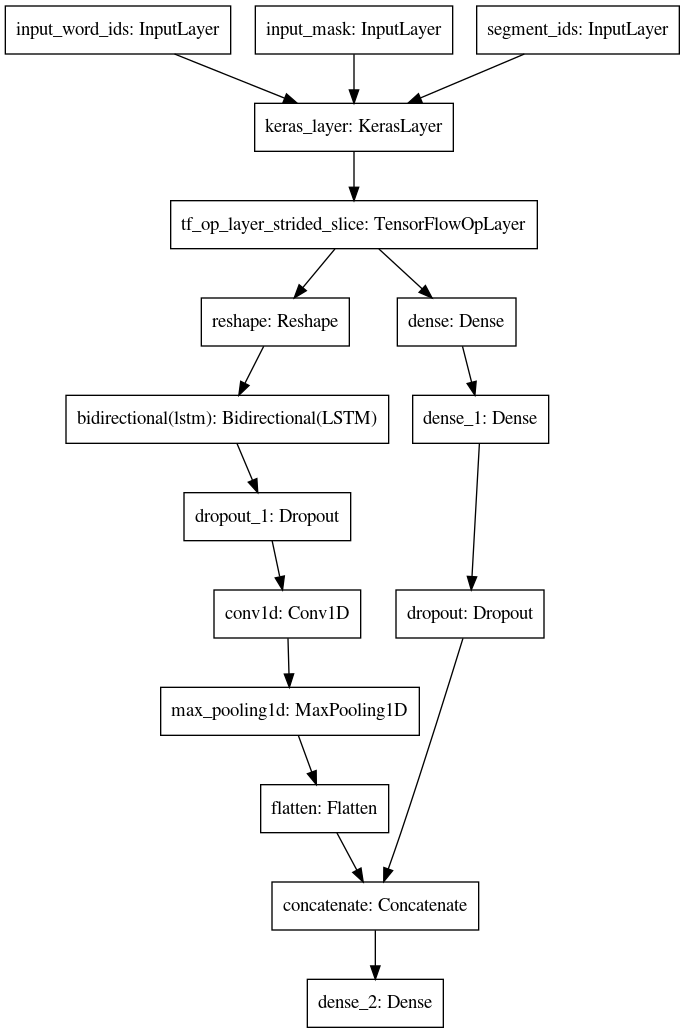

In [15]:
tf.keras.utils.plot_model(model)

In [16]:
train_history = model.fit(train_input,Y_train,epochs=5,batch_size=16,validation_split=0.2)

Epoch 1/5
305/305 [==============================] - 30s 99ms/step - loss: 0.8676 - accuracy: 0.5942 - auc: 0.5868 - val_loss: 0.8634 - val_accuracy: 0.5952 - val_auc: 0.6378
Epoch 2/5
305/305 [==============================] - 28s 92ms/step - loss: 0.8522 - accuracy: 0.6168 - auc: 0.6550 - val_loss: 0.8521 - val_accuracy: 0.6076 - val_auc: 0.6891
Epoch 3/5
305/305 [==============================] - 28s 92ms/step - loss: 0.8420 - accuracy: 0.6295 - auc: 0.6947 - val_loss: 0.8415 - val_accuracy: 0.6207 - val_auc: 0.7223
Epoch 4/5
305/305 [==============================] - 28s 92ms/step - loss: 0.8335 - accuracy: 0.6412 - auc: 0.7168 - val_loss: 0.8313 - val_accuracy: 0.6404 - val_auc: 0.7437
Epoch 5/5
305/305 [==============================] - 28s 92ms/step - loss: 0.8229 - accuracy: 0.6669 - auc: 0.7409 - val_loss: 0.8214 - val_accuracy: 0.6675 - val_auc: 0.7594


# Testing and Refinement

In [17]:
predictions = model.predict(test_input)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

def pred_return(x):
    if x>=0.5:
        return 1
    else:
        return 0

print(classification_report([pred_return(x) for x in predictions],Y_test))
print(confusion_matrix([pred_return(x) for x in predictions],Y_test))

              precision    recall  f1-score   support

           0       0.98      0.65      0.78      1306
           1       0.30      0.90      0.45       217

    accuracy                           0.69      1523
   macro avg       0.64      0.78      0.62      1523
weighted avg       0.88      0.69      0.73      1523

[[851 455]
 [ 21 196]]


# Submission Testing and Saving

In [19]:
test_df = pd.read_csv('../input/nlp-getting-started/test.csv')

In [20]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [21]:
test_df['text_clean'] = test_df['text'].apply(lambda x: clean_text(x))
test_df['text_lowered'] = test_df['text_clean'].apply(lambda x: x.lower())

In [22]:
test_input = bert_encoding(test_df['text_lowered'],tokenizer,max_len=50)

In [23]:
predictions = model.predict(test_input)
test_df['target'] = [pred_return(x) for x in predictions]
test_df.drop(['keyword','location','text','text_clean','text_lowered'],axis=1,inplace=True)
test_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,1


In [24]:
assert len(test_df['target']) == 3263

In [25]:
test_df.to_csv('submission.csv',index=False,header=True)